# Ejercicio - Detección de tumores utilizand CNN y Attention maps

El siguiente ejercicio tiene como objetivo poder identificar posibles tumores cerebrales utilizando redes CNN y attention maps.
Requerimientos:

- Crear una red CNN desde 0 y entrenarla
- Utilizar una red pre-entrenada (Resnet)
- Comparar resultados.

Se recomienda ejecutar el notebook en Kaggle y referenciar el siguiente set ded datos. [Link](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [24]:
os.chdir('/kaggle/input/brain-tumor-mri-dataset/Training')
print(os.listdir())

['pituitary', 'notumor', 'meningioma', 'glioma']


## EDA

In [25]:
def count_files(folder_names = []):
    for f_name in folder_names:
        count = len(os.listdir(f'{f_name}'))
        print(f'Folder: {f_name} contains {count} images')

In [26]:
count_files(['glioma', 'notumor', 'meningioma', 'pituitary'])

Folder: glioma contains 1321 images
Folder: notumor contains 1595 images
Folder: meningioma contains 1339 images
Folder: pituitary contains 1457 images


## Preprocessing the images

In [27]:
def preprocessor(image):
    # Applying normalization to the image
    image = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX)    
    
    image = np.array(image)/255.0
    return image

### Loading Dataset

In [28]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocessor)


In [29]:
train = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',  # this is the target directory
    target_size=(256, 256),  # all images will be resized to 150x150
    batch_size=32,
    subset='training',
    class_mode='sparse')

val = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',  # this is the target directory
    target_size=(256, 256),  # all images will be resized to 150x150
    batch_size=32,
    subset='validation',
    class_mode='sparse')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [30]:
test = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Testing',
    target_size= (256, 256),
    batch_size=32,
    class_mode='sparse'
)

Found 1311 images belonging to 4 classes.


In [31]:
# Preventing the model from having different accuracies on different iterations
tf.keras.utils.set_random_seed(0)
#tf.config.experimental.enable_op_determinism()

## CNN

Desarrollar una CNN desde 0.

>HINT: Utilizar una red secuencial con dos capas convolucionales, dos capas densas, y la capa de salida tiene que contener la cantidad de categorías que provienen del dataset de imágenes

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

model = Sequential()

# BASE MODEL
model.add(Conv2D(32,(3,3),input_shape=(256,256,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

#TOP MODEL
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(4,activation='softmax'))#TODO

In [33]:
model.compile(optimizer='Adam', #TODO
              loss=SparseCategoricalCrossentropy(), #TODO
              metrics=['sparse_categorical_accuracy'])

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 246016)            0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [35]:
# Implementar EarlyStopping
callback = keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.01,
                                         patience=5, #TODO
                                         verbose=0,
                                         mode="auto",
                                         baseline=None,
                                         restore_best_weights=True)

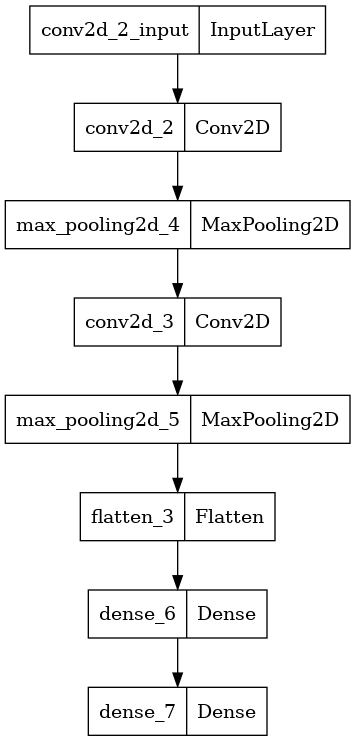

In [36]:
from keras.utils import plot_model
plot_model(model, to_file='/kaggle/working/cnn.png')

In [37]:
history = model.fit(train, #TODO
                    epochs=20,  #TODO
                    validation_data=val, 
                    callbacks=[callback]) #TODO

Epoch 1/20
143/143 [==============================] - 87s 586ms/step - loss: 1.1711 - sparse_categorical_accuracy: 0.5907 - val_loss: 0.9249 - val_sparse_categorical_accuracy: 0.6442
Epoch 2/20
143/143 [==============================] - 82s 577ms/step - loss: 0.5861 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.8949 - val_sparse_categorical_accuracy: 0.6705
Epoch 3/20
143/143 [==============================] - 82s 576ms/step - loss: 0.5317 - sparse_categorical_accuracy: 0.7882 - val_loss: 0.9361 - val_sparse_categorical_accuracy: 0.6705
Epoch 4/20
143/143 [==============================] - 82s 573ms/step - loss: 0.4905 - sparse_categorical_accuracy: 0.8079 - val_loss: 0.8260 - val_sparse_categorical_accuracy: 0.7160
Epoch 5/20
143/143 [==============================] - 83s 581ms/step - loss: 0.4814 - sparse_categorical_accuracy: 0.8160 - val_loss: 1.2343 - val_sparse_categorical_accuracy: 0.6512
Epoch 6/20
143/143 [==============================] - 82s 573ms/step - loss: 0.4390 -

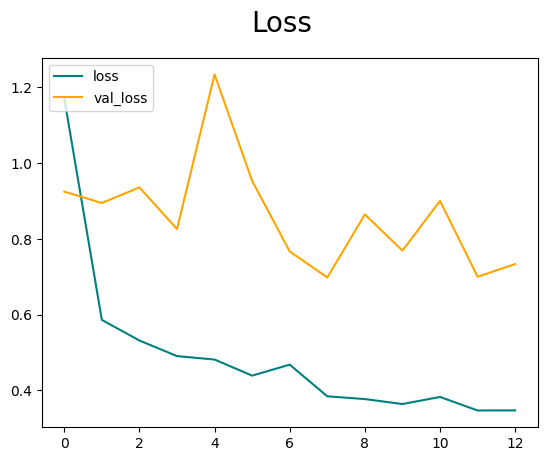

In [38]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

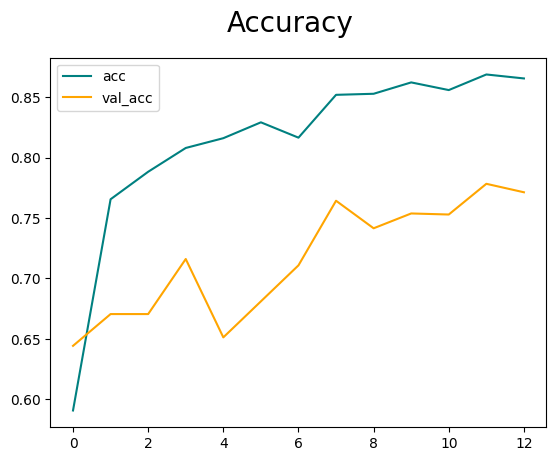

In [39]:
fig = plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], color='teal', label='acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## RESNET

Implementar `ResNet50`.

>HINT: Utilizar una red secuencial con dos capas convolucionales, dos capas densas, y la capa de salida tiene que contener la cantidad de categorías que provienen del dataset de imágenes

In [40]:
from keras.applications.resnet import ResNet50

In [41]:
model_resnet = Sequential()
model_resnet.add(ResNet50(include_top=False, #TODO
                          weights='imagenet', #TODO
                          input_shape=(256, 256, 3)))
model_resnet.add(MaxPooling2D())
model_resnet.add(Flatten())
model_resnet.add(Dropout(0.3))
model_resnet.add(Dense(150, activation='relu'))
model_resnet.add(Dense(4, activation='softmax')) #TODO
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['sparse_categorical_accuracy'])

In [42]:
model_resnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 2048)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 150)               4915350   
                                                                 
 dense_9 (Dense)             (None, 4)                 604       
                                                      

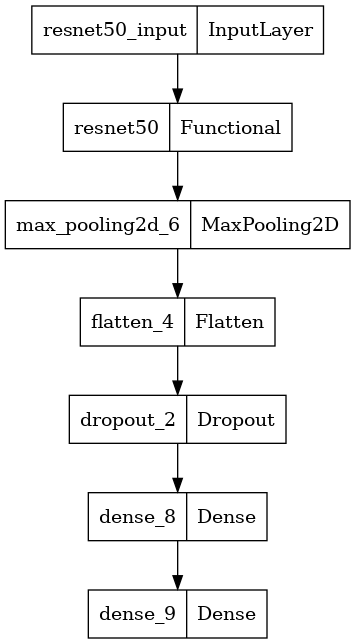

In [43]:
plot_model(model_resnet, to_file='/kaggle/working/resnet.png')

In [44]:
history_resnet = model_resnet.fit(train, 
                                  epochs=20, 
                                  validation_data=val, 
                                  callbacks=[callback])

Epoch 1/20
143/143 [==============================] - 95s 623ms/step - loss: 0.4881 - sparse_categorical_accuracy: 0.8716 - val_loss: 3.0779 - val_sparse_categorical_accuracy: 0.2726
Epoch 2/20
143/143 [==============================] - 86s 603ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.9521 - val_loss: 3.5093 - val_sparse_categorical_accuracy: 0.2515
Epoch 3/20
143/143 [==============================] - 88s 611ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.9657 - val_loss: 2.4083 - val_sparse_categorical_accuracy: 0.4277
Epoch 4/20
143/143 [==============================] - 86s 604ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9748 - val_loss: 5.3048 - val_sparse_categorical_accuracy: 0.3260
Epoch 5/20
143/143 [==============================] - 86s 602ms/step - loss: 0.0449 - sparse_categorical_accuracy: 0.9849 - val_loss: 5.6858 - val_sparse_categorical_accuracy: 0.4163
Epoch 6/20
143/143 [==============================] - 85s 596ms/step - loss: 0.0362 -

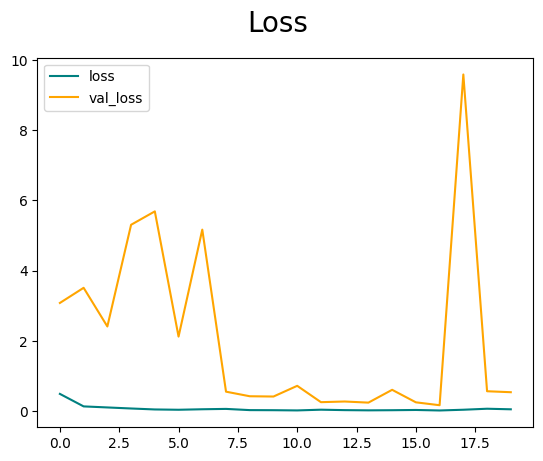

In [45]:
fig = plt.figure()
plt.plot(history_resnet.history['loss'], color='teal', label='loss')
plt.plot(history_resnet.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

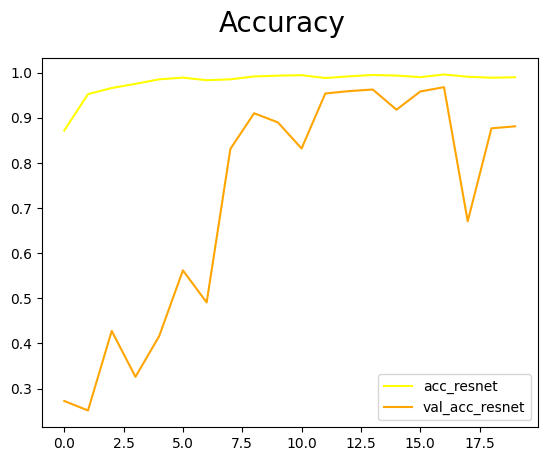

In [46]:
fig = plt.figure()
plt.plot(history_resnet.history['sparse_categorical_accuracy'], color='yellow', label='acc_resnet')
plt.plot(history_resnet.history['val_sparse_categorical_accuracy'], color='orange', label='val_acc_resnet')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

## Testing the model

In [47]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, SparseCategoricalAccuracy

In [48]:
def assesment(model, data=test):
    # Instanciating the metrics functions
    pre = Precision()
    re = Recall()
    acc = CategoricalAccuracy()
    
    # Resetting the state of these parameters to prevent any sort of conflict in the future.
    pre.reset_state()
    re.reset_state()
    acc.reset_state()

    # Creating a list to store all the predictions and true values.
    output_pred = []
    output_true = []

    # Iterating over the test data and getting the predictions to update the metric values
    for batches in range(len(test)):
        Y_pred = model.predict(test[batches][0])
        others = np.array([sample.argmax() for sample in Y_pred])
        Y_true = test[batches][1]
        output_pred.append(others)
        output_true.append(Y_true)
        pre.update_state(Y_true, others)
        re.update_state(Y_true, others)
        acc.update_state(Y_true, others)

    # Calculating the F1 score 
    F1 = 2 * (pre.result() * re.result()) / (pre.result() + re.result())
    print(f'Model metrics: F1-score = {F1}  Recall = {re.result()}  Precision = {pre.result()}  Accuracy = {acc.result()}')

    # Creating a 1d predictions and True values
    output_pred = np.concatenate(output_pred)
    output_true = np.concatenate(output_true)
  
    return (output_pred, output_true, np.round(pre.result(), 2), np.round(re.result(), 2), np.round(acc.result(), 2), np.round(F1, 2))

In [49]:
print('Metrics of the CNN model')
print('_' * 20)
print('+' * 20)
output_pred_cnn, output_true_cnn, precision_cnn, recall_cnn, acc_cnn, F1_cnn = assesment(model=model)

Metrics of the CNN model
____________________
++++++++++++++++++++
1/1 [==============================] - 0s 256ms/step
Model metrics: F1-score = 0.9310344457626343  Recall = 0.9347180724143982  Precision = 0.9273797869682312  Accuracy = 0.8048780560493469


In [50]:
print('Metrics of the RESNET model')
print('_' * 20)
print('+' * 20)
output_pred_resnet, output_true_resnet, precision_resnet, recall_resnet, acc_resnet, F1_resnet = assesment(model=model_resnet)

Metrics of the RESNET model
____________________
++++++++++++++++++++
1/1 [==============================] - 2s 2s/step
Model metrics: F1-score = 0.9890873432159424  Recall = 0.9861523509025574  Precision = 0.9920397996902466  Accuracy = 0.9268292784690857


## Saving Models

In [51]:
model.save('/kaggle/working/cnn_model.h5')
model_resnet.save('/kaggle/working/resnet_model.h5')

## Model explainability

En el siguiente apartado evaluaremos las imágenes utilizando `GradCam`

### CNN Model

In [92]:
!pip install tf-explain --quiet

In [93]:
from tf_explain.core import GradCAM
import seaborn as sns
import pandas as pd

In [128]:
def proper_img(l=1):
    label = ''
    init_value = 0
    while label != l:
        test_img = test[init_value][0][0]
        label = int(test[init_value][1][0])
        init_value+=1
    
    return test_img, label

In [211]:
test_img, label = proper_img(1)

In [212]:
print(label)

1


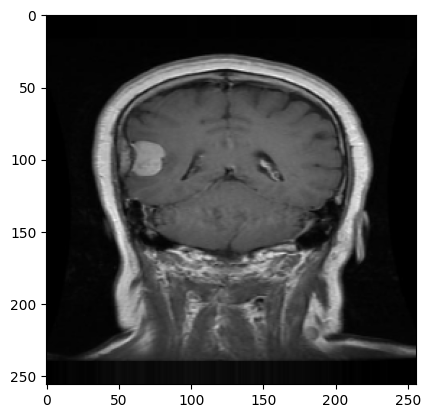

In [213]:
plt.imshow(test_img)

In [214]:
label = int(label)
print(label)

1


In [215]:
# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [216]:
# Instantiation of the explainer - GradCam()
explainer = GradCAM() #TODO

In [217]:
validation_data = np.array([np.expand_dims(test_img, 0), None])

/tmp/ipykernel_32/3553063616.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_data = np.array([np.expand_dims(test_img, 0), None])


In [218]:
# Call to explain() method
output = explainer.explain(validation_data=validation_data, 
                           model=model, 
                           class_index=label)

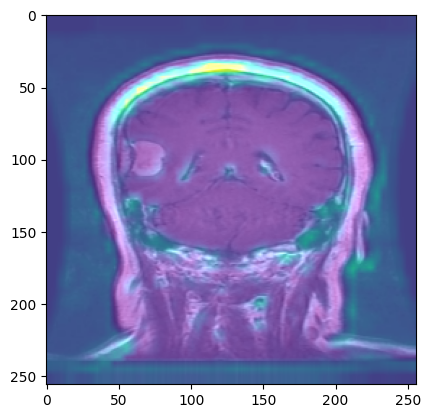

In [219]:
plt.imshow(output)

In [220]:
plt.imsave('/kaggle/working/cnn_grad.png', output)

### Resnet

In [221]:
# Instantiation of the explainer - GradCam()
explainer_resnet = GradCAM() #TODO

In [222]:
# Call to explain() method
output_resnet = explainer_resnet.explain(validation_data=validation_data, model=model_resnet, class_index=1)

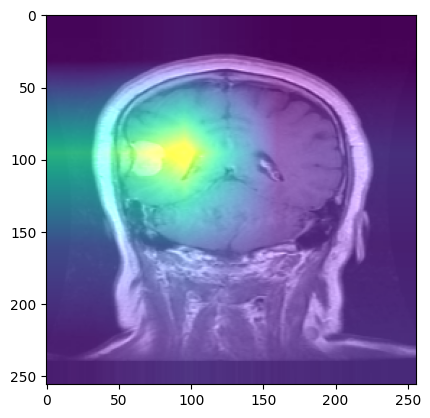

In [223]:
plt.imshow(output_resnet)

In [224]:
plt.imsave('/kaggle/working/resnet_grad.png', output_resnet)

In [225]:
test.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

## Exporting the metrics

In [226]:
data = {
    'model_type': ['CNN', 'ResNET'],
    'Sparse_Categorical_Accuracy': [acc_cnn, acc_resnet],
    'Recall': [recall_cnn, recall_resnet], 
    'Precision': [precision_cnn, precision_resnet],
    'F1 Score': [F1_cnn, F1_resnet]
}

metrics_df = pd.DataFrame(data)
metrics_df


,model_type,Sparse_Categorical_Accuracy,Recall,Precision,F1 Score
0,CNN,0.80,0.93,0.93,0.93
1,ResNET,0.93,0.99,0.99,0.99
